In [100]:
%env JAX_PLATFORM_NAME=cpu

import jaxtyping  # noqa: F401

# %load_ext jaxtyping
# %jaxtyping.typechecker beartype.beartype

env: JAX_PLATFORM_NAME=cpu


In [101]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax

from tqdm.notebook import trange

from jaxtyping import Array, Bool, Float
from jax.typing import ArrayLike
from typing import Protocol, runtime_checkable, Any

# from chaogatenn.chaogate import ChaoGate
from chaogatenn.maps import LogisticMap, MapLike
from chaogatenn.utils import grad_norm

In [102]:
class ChaoGate(eqx.Module):
    DELTA: Float[Array, ""]
    X0: Float[Array, ""]
    X_THRESHOLD: Float[Array, ""]
    Map: MapLike

    def __init__(
        self, DELTA: ArrayLike, X0: ArrayLike, X_THRESHOLD: ArrayLike, Map: MapLike
    ):
        self.DELTA = jnp.array(DELTA)
        self.X0 = jnp.array(X0)
        self.X_THRESHOLD = jnp.array(X_THRESHOLD)
        self.Map = Map

    def __call__(self, x: Float[Array, "2"]) -> Float[Array, ""]:
        x1, x2 = x

        return jax.nn.sigmoid(
            self.Map(self.X0 + x1 * self.DELTA + x2 * self.DELTA) - self.X_THRESHOLD
        )

In [103]:
@runtime_checkable
class GateLike(Protocol):
    params: Any

    def __call__(self, x: ArrayLike) -> ArrayLike: ...

In [104]:
Map = LogisticMap(a=4.0)
SEED = 0

In [105]:
X = jnp.array([[0, 0], [0, 1], [1, 0], [1, 1]])  # Input combinations
XNOR_Y = jnp.array([1, 0, 0, 1])  # XNOR

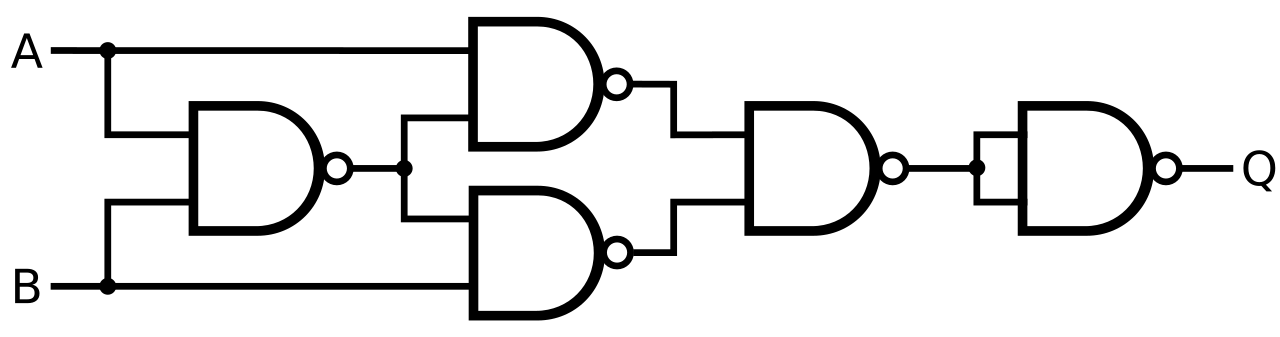

In [106]:
DELTA, X0, X_THRESHOLD = jax.random.normal(jax.random.PRNGKey(0), (3, 5))
nand_1 = ChaoGate(DELTA=DELTA[0], X0=X0[0], X_THRESHOLD=X_THRESHOLD[0], Map=Map)
nand_2 = ChaoGate(DELTA=DELTA[1], X0=X0[1], X_THRESHOLD=X_THRESHOLD[1], Map=Map)
nand_3 = ChaoGate(DELTA=DELTA[2], X0=X0[2], X_THRESHOLD=X_THRESHOLD[2], Map=Map)
nand_4 = ChaoGate(DELTA=DELTA[3], X0=X0[3], X_THRESHOLD=X_THRESHOLD[3], Map=Map)
nand_5 = ChaoGate(DELTA=DELTA[4], X0=X0[4], X_THRESHOLD=X_THRESHOLD[4], Map=Map)


In [107]:
def compute_loss(
    gate: GateLike, x: Bool[Array, "batch 2"], y: Bool[Array, "batch"]
) -> Float[Array, ""]:
    pred = jax.vmap(gate)(x)
    loss = -jnp.mean(y * jnp.log(pred + 1e-15) + (1 - y) * jnp.log(1 - pred + 1e-15))

    return loss

In [108]:
@eqx.filter_jit
def make_step(
    gate: GateLike,
    X: Bool[Array, "batch 2"],
    y: Bool[Array, "batch"],
    optim: optax.GradientTransformation,
    opt_state: optax.OptState,
) -> (Float[Array, "dim"], ChaoGate, optax.OptState):  # type: ignore
    loss, grads = jax.value_and_grad(compute_loss)(gate, X, y)

    updates, opt_state = optim.update(grads, opt_state)

    gate = eqx.apply_updates(gate, updates)

    return loss, gate, opt_state

In [109]:
# Construct XNOR using NAND gates
class XNORFromNAND(eqx.Module):
    nand_1: ChaoGate  # For NAND(A, B)
    nand_2: ChaoGate  # For NAND(NAND(A, B), NAND(A, B)) -> A AND B
    nand_3: ChaoGate  # For NAND(A, A) -> NOT A
    nand_4: ChaoGate  # For NAND(B, B) -> NOT B
    nand_5: ChaoGate  # For final OR-like step: NAND(NOT A, NOT B)

    def __call__(self, x: jnp.ndarray):
        a, b = x

        nand_ab = self.nand_1(x)
        and_ab = self.nand_2(jnp.array([nand_ab, nand_ab]))

        not_a = self.nand_3(jnp.array([a, a])) > 0.5
        not_b = self.nand_4(jnp.array([b, b])) > 0.5

        # NOT A OR NOT B
        or_ab = self.nand_5(jnp.array([not_a, not_b])) > 0.5

        # A XNOR B = AND(A, B) OR (NOT A AND NOT B)
        xnor_output = self.nand_2(jnp.array([and_ab, or_ab], dtype=bool))

        return xnor_output

In [110]:
gate = XNORFromNAND(
    nand_1=nand_1,
    nand_2=nand_2,
    nand_3=nand_3,
    nand_4=nand_4,
    nand_5=nand_5,
)

In [111]:
jax.vmap(gate)(X)

Array([5.2896507e-08, 5.2896507e-08, 5.2896507e-08, 5.2896507e-08],      dtype=float32)

In [112]:
optim = optax.adabelief(learning_rate=3e-4)
opt_state = optim.init(eqx.filter(gate, eqx.is_inexact_array))

In [113]:
epochs = 4_000

for epoch in trange(epochs):
    loss, gate, opt_state = make_step(gate, X, XNOR_Y, optim, opt_state)  # type: ignore
    _, grads = compute_loss(gate, X, XNOR_Y)
    grad_norm_value = grad_norm(grads)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss}, Grad Norm: {grad_norm_value}")

    if loss < 1e-3:
        break

  0%|          | 0/4000 [00:00<?, ?it/s]

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [66]:
# NAND function using the ChaoGate
def nand_gate(a, b, gate: ChaoGate):
    # Simulate NAND behavior: ~(A & B) using ChaoGate
    return gate(jnp.array([a, b], dtype=bool))


# Construct XNOR using NAND gates
class XNORFromNAND(eqx.Module):
    nand_gate_1: ChaoGate  # For NAND(A, B)
    nand_gate_2: ChaoGate  # For NAND(NAND(A, B), NAND(A, B)) -> A AND B
    nand_gate_3: ChaoGate  # For NAND(A, A) -> NOT A
    nand_gate_4: ChaoGate  # For NAND(B, B) -> NOT B
    nand_gate_5: ChaoGate  # For final OR-like step: NAND(NOT A, NOT B)

    def __call__(self, inputs: jnp.ndarray):
        a, b = inputs

        # Step-by-step XNOR construction using NAND gates
        nand_ab = nand_gate(a, b, self.nand_gate_1)  # NAND(A, B)
        and_ab = nand_gate(nand_ab, nand_ab, self.nand_gate_2)  # A AND B

        not_a = nand_gate(a, a, self.nand_gate_3)  # NOT A
        not_b = nand_gate(b, b, self.nand_gate_4)  # NOT B

        or_ab = nand_gate(not_a, not_b, self.nand_gate_5)  # NOT A OR NOT B

        # Final step: A XNOR B = AND(A, B) OR (NOT A AND NOT B)
        xnor_output = nand_gate(and_ab, or_ab, self.nand_gate_2)  # Final output
        return xnor_output


# Initialize a network of ChaoGates
def initialize_xnor_network(key):
    nand_gate_1 = ChaoGate(
        DELTA=jax.random.uniform(key, ()),
        X0=jax.random.uniform(key, ()),
        X_THRESHOLD=jax.random.uniform(key, ()),
        Map=Map,
    )
    nand_gate_2 = ChaoGate(
        DELTA=jax.random.uniform(key, ()),
        X0=jax.random.uniform(key, ()),
        X_THRESHOLD=jax.random.uniform(key, ()),
        Map=Map,
    )
    nand_gate_3 = ChaoGate(
        DELTA=jax.random.uniform(key, ()),
        X0=jax.random.uniform(key, ()),
        X_THRESHOLD=jax.random.uniform(key, ()),
        Map=Map,
    )
    nand_gate_4 = ChaoGate(
        DELTA=jax.random.uniform(key, ()),
        X0=jax.random.uniform(key, ()),
        X_THRESHOLD=jax.random.uniform(key, ()),
        Map=Map,
    )
    nand_gate_5 = ChaoGate(
        DELTA=jax.random.uniform(key, ()),
        X0=jax.random.uniform(key, ()),
        X_THRESHOLD=jax.random.uniform(key, ()),
        Map=Map,
    )

    return XNORFromNAND(
        nand_gate_1=nand_gate_1,
        nand_gate_2=nand_gate_2,
        nand_gate_3=nand_gate_3,
        nand_gate_4=nand_gate_4,
        nand_gate_5=nand_gate_5,
    )


# Input-output pairs for an XNOR gate
def xnor_truth_table():
    inputs = jnp.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    outputs = jnp.array([1, 0, 0, 1])  # XNOR truth table
    return inputs, outputs


# Loss function to train the network
def loss_fn(model, inputs, targets):
    preds = jax.vmap(model)(inputs)
    return jnp.mean((preds - targets) ** 2)


# Training function
def train_xnor(model, optimizer, inputs, targets, steps=1000):
    opt_state = optimizer.init(model)

    @jax.jit
    def step(model, opt_state, inputs, targets):
        loss, grads = jax.value_and_grad(loss_fn)(model, inputs, targets)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss

    for step_idx in range(steps):
        model, opt_state, loss = step(model, opt_state, inputs, targets)
        if step_idx % 100 == 0:
            print(f"Step {step_idx}, Loss: {loss}")

    return model


# Main: Create and train the XNOR gate using ChaoGates
key = jax.random.PRNGKey(0)

# Initialize the XNOR network with 5 NAND gates
xnor_model = initialize_xnor_network(key)

# Define optimizer (using Optax)
optimizer = optax.adam(learning_rate=0.01)

# Get the truth table for the XNOR gate
inputs, targets = xnor_truth_table()

# Train the XNOR gate model
trained_xnor = train_xnor(xnor_model, optimizer, inputs, targets)


Step 0, Loss: 0.3694663643836975
Step 100, Loss: 0.2500004172325134
Step 200, Loss: 0.25
Step 300, Loss: 0.25
Step 400, Loss: 0.25
Step 500, Loss: 0.25
Step 600, Loss: 0.25
Step 700, Loss: 0.25
Step 800, Loss: 0.25
Step 900, Loss: 0.25


In [67]:
pred_ys = jax.vmap(trained_xnor)(X)
num_correct = jnp.sum((pred_ys > 0.5) == XNOR_Y)
final_accuracy = (num_correct / len(X)).item()
print(f"final_accuracy={final_accuracy}")

final_accuracy=0.5


In [68]:
pred_ys = jax.vmap(trained_xnor.nand_gate_1)(X)
num_correct = jnp.sum((pred_ys > 0.5) == jnp.array([1, 1, 1, 0], dtype=bool))
final_accuracy = (num_correct / len(X)).item()
print(f"final_accuracy={final_accuracy}")

final_accuracy=1.0


In [85]:
a = jnp.array([0.2, 0.3, 0.6])
a > 0.5

Array([False, False,  True], dtype=bool)